# 2.4 Backpropagation

## Tensorflow Walkthrough

### 1. Import Dependencies

In [1]:
import os

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.ops import nn_ops, gen_nn_ops
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.models_2_4 import MNIST_CNN

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

images = mnist.train.images
labels = mnist.train.labels

logdir = './tf_logs/2_4_DC/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Building Graph

In [2]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    DNN = MNIST_CNN('CNN')

    # Setup training process
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.float32, [None, 10], name='Y')

    activations, logits = DNN(X)
    
    tf.add_to_collection('BP', X)
    tf.add_to_collection('BP', logits)
    
    for activation in activations:
        tf.add_to_collection('BP', activation)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=DNN.vars)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Building Subgraph

In [3]:
with tf.name_scope('Prototype'):
    
    lmda = tf.placeholder(tf.float32, [], name='lambda')
    X_prototype = tf.get_variable('X_prototype', shape=[10, 784], initializer=tf.constant_initializer(0.))

    _, logits_prototype = DNN(X_prototype, reuse=True)
    
    cost_prototype = 1 - tf.trace(logits_prototype) + lmda * tf.nn.l2_loss(X_prototype)

    optimizer_prototype = tf.train.AdamOptimizer().minimize(cost_prototype, var_list=[X_prototype])

# Add the subgraph nodes to a collection so that they can be used after training of the network
tf.add_to_collection('prototype', lmda)
tf.add_to_collection('prototype', X_prototype)
tf.add_to_collection('prototype', logits_prototype)
tf.add_to_collection('prototype', cost_prototype)
tf.add_to_collection('prototype', optimizer_prototype)

### 4. Training Network

In [4]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 15
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        
        # zero-center the images
        mean = np.mean(batch_xs, axis=0, keepdims=True)
        batch_xs = batch_xs - mean
        
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

sess.close()

Epoch: 0001 cost = 0.169085310 accuracy = 0.946727280
Epoch: 0002 cost = 0.044592938 accuracy = 0.986218191
Epoch: 0003 cost = 0.028531287 accuracy = 0.991000008
Epoch: 0004 cost = 0.024309815 accuracy = 0.992200007
Epoch: 0005 cost = 0.016091269 accuracy = 0.994600005
Epoch: 0006 cost = 0.013665342 accuracy = 0.995690913
Epoch: 0007 cost = 0.013399836 accuracy = 0.995763640
Epoch: 0008 cost = 0.010240791 accuracy = 0.996636367
Epoch: 0009 cost = 0.010054544 accuracy = 0.996763639
Epoch: 0010 cost = 0.008347637 accuracy = 0.997290912
Epoch: 0011 cost = 0.008589237 accuracy = 0.997090912
Epoch: 0012 cost = 0.008013549 accuracy = 0.997472730
Epoch: 0013 cost = 0.005356289 accuracy = 0.998181820
Epoch: 0014 cost = 0.004136225 accuracy = 0.998800001
Epoch: 0015 cost = 0.006400488 accuracy = 0.997945457
Accuracy: 0.9862


### 5. Restoring Graph

In [5]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

activations = tf.get_collection('BP')
X = activations[0]
logits = activations[1]

prototype = tf.get_collection('prototype')
lmda = prototype[0]
X_prototype = prototype[1]
cost_prototype = prototype[3]
optimizer_prototype = prototype[4]

sample_imgs = [images[np.argmax(labels, axis=1) == i][5] for i in range(10)]

INFO:tensorflow:Restoring parameters from ./tf_logs/2_4_DC/model


### 6. Class Model Visualization

In [6]:
img_means = []
for i in range(10):
    img_means.append(np.mean(images[np.argmax(labels, axis=1) == i], axis=0))

for epoch in range(5000):
    _, c = sess.run([optimizer_prototype, cost_prototype], feed_dict={lmda: 0.01})
    
    if epoch % 500 == 0:
        print('Epoch: {:05d} Cost = {:.9f}'.format(epoch, np.sum(c)))
    
X_prototypes = sess.run(X_prototype)

Epoch: 00000 Cost = 2.348793745
Epoch: 00500 Cost = -817.845092773
Epoch: 01000 Cost = -1951.692382812
Epoch: 01500 Cost = -2955.781494141
Epoch: 02000 Cost = -3905.116455078
Epoch: 02500 Cost = -4824.121093750
Epoch: 03000 Cost = -5725.052246094
Epoch: 03500 Cost = -6610.922851562
Epoch: 04000 Cost = -7481.562011719
Epoch: 04500 Cost = -8331.448242188


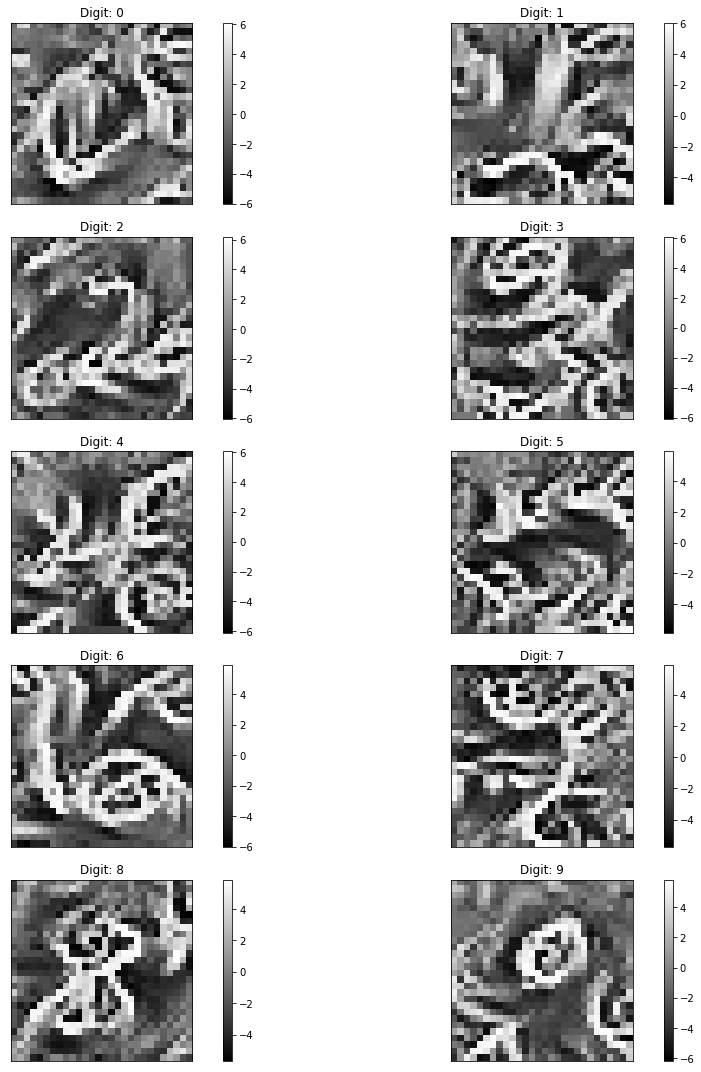

In [7]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(np.reshape(X_prototypes[2 * i], [28, 28]), cmap='gray', interpolation='none')
    plt.title('Digit: {}'.format(2 * i))
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(np.reshape(X_prototypes[2 * i + 1], [28, 28]), cmap='gray', interpolation='none')
    plt.title('Digit: {}'.format(2 * i + 1))
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()

plt.tight_layout()

### 7. Image-Specific Class Saliency Visualization

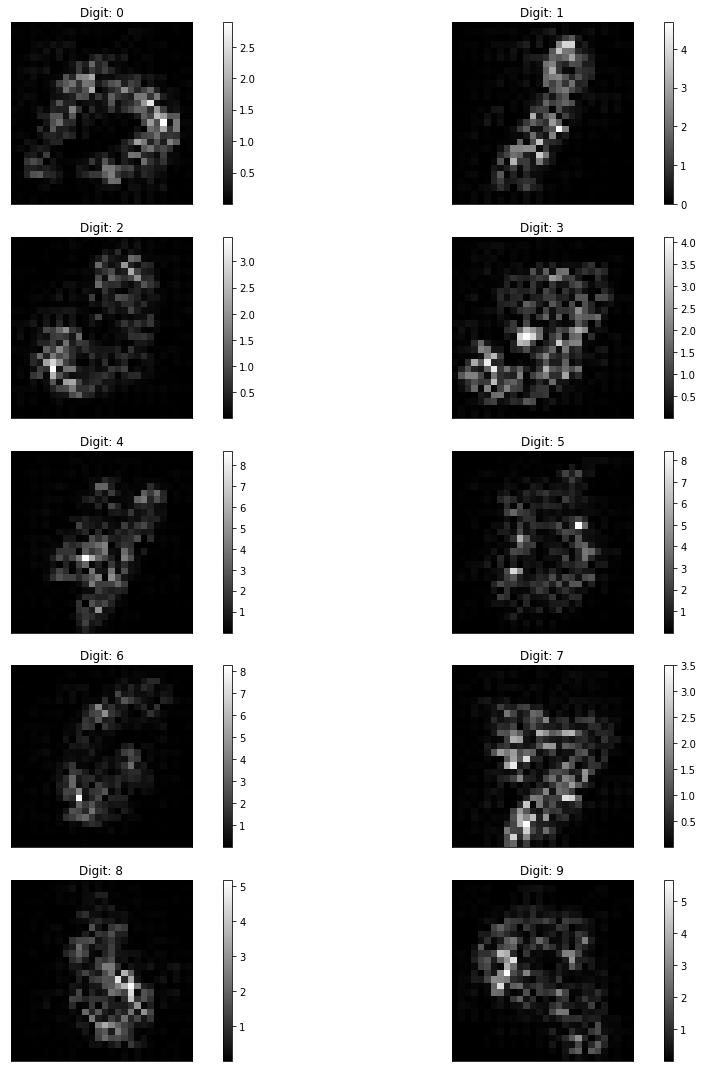

In [8]:
saliency = tf.abs(tf.gradients(logits, X))

hmaps = np.squeeze(sess.run(saliency, feed_dict={X: sample_imgs}), axis=0)

plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(np.reshape(hmaps[2 * i], [28, 28]), cmap='gray', interpolation='none')
    plt.title('Digit: {}'.format(2 * i))
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(np.reshape(hmaps[2 * i + 1], [28, 28]), cmap='gray', interpolation='none')
    plt.title('Digit: {}'.format(2 * i + 1))
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()

plt.tight_layout()